# Binary Classification with Bank Churn Dataset.
## This is a kaggle playground competition to improve machine learning and data science skills. Link to the competition can be found [here](https://www.kaggle.com/competitions/playground-series-s4e1/overview)


## Importing Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns
import numpy as np
pd.options.mode.copy_on_write = True

## Data description && EDA

* **Customer ID:** A unique identifier for each customer
* **Surname:** The customer's surname or last name
* **Credit Score:** A numerical value representing the customer's credit score
* **Geography:** The country where the customer resides (France, Spain or Germany)
* **Gender:** The customer's gender (Male or Female)
* **Age:** The customer's age.
* **Tenure:** The number of years the customer has been with the bank
* **Balance:** The customer's account balance
* **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
* **HasCrCard:** Whether the customer has a credit card (1 = yes, 0 = no)
* **IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no)
* **EstimatedSalary:** The estimated salary of the customer
* **Exited:** Whether the customer has churned (1 = yes, 0 = no)

In [3]:
train_data = pd.read_csv("../data/bank_churn_competition/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [4]:
columns_to_drop = ["Exited", "id", "Surname", "CustomerId"]
relevant_feature_columns = [column for column in list(train_data.columns) if column not in columns_to_drop]
target_column = ["Exited"]

In [5]:
for column in relevant_feature_columns:
    data = train_data[column]
    if data.dtype == "float64" or data.dtype == "int64": 
            print(f"{column}:\nMax: {data.max():.2f}\n"
                  f"Min: {data.min():.2f}\n"
                  f"Mean: {data.mean():.3f}"
                  f"\nMedian {data.median():.3f}")
            print("----------\n")

CreditScore:
Max: 850.00
Min: 350.00
Mean: 656.454
Median 659.000
----------

Age:
Max: 92.00
Min: 18.00
Mean: 38.126
Median 37.000
----------

Tenure:
Max: 10.00
Min: 0.00
Mean: 5.020
Median 5.000
----------

Balance:
Max: 250898.09
Min: 0.00
Mean: 55478.087
Median 0.000
----------

NumOfProducts:
Max: 4.00
Min: 1.00
Mean: 1.554
Median 2.000
----------

HasCrCard:
Max: 1.00
Min: 0.00
Mean: 0.754
Median 1.000
----------

IsActiveMember:
Max: 1.00
Min: 0.00
Mean: 0.498
Median 0.000
----------

EstimatedSalary:
Max: 199992.48
Min: 11.58
Mean: 112574.823
Median 117948.000
----------


* Feature columns seem to be normally distributed. Mean and Median for each column are very close. 

### Examining correlation between feature columns and target output. 

In [6]:
correlation = train_data[relevant_feature_columns + target_column]

In [7]:
geo_encoder = LabelEncoder()
output = geo_encoder.fit_transform(train_data["Geography"])
correlation["Geography"] = output

In [8]:
gender_encoder = LabelEncoder()
gender_output = gender_encoder.fit_transform(correlation["Gender"])
correlation["Gender"]  = gender_output

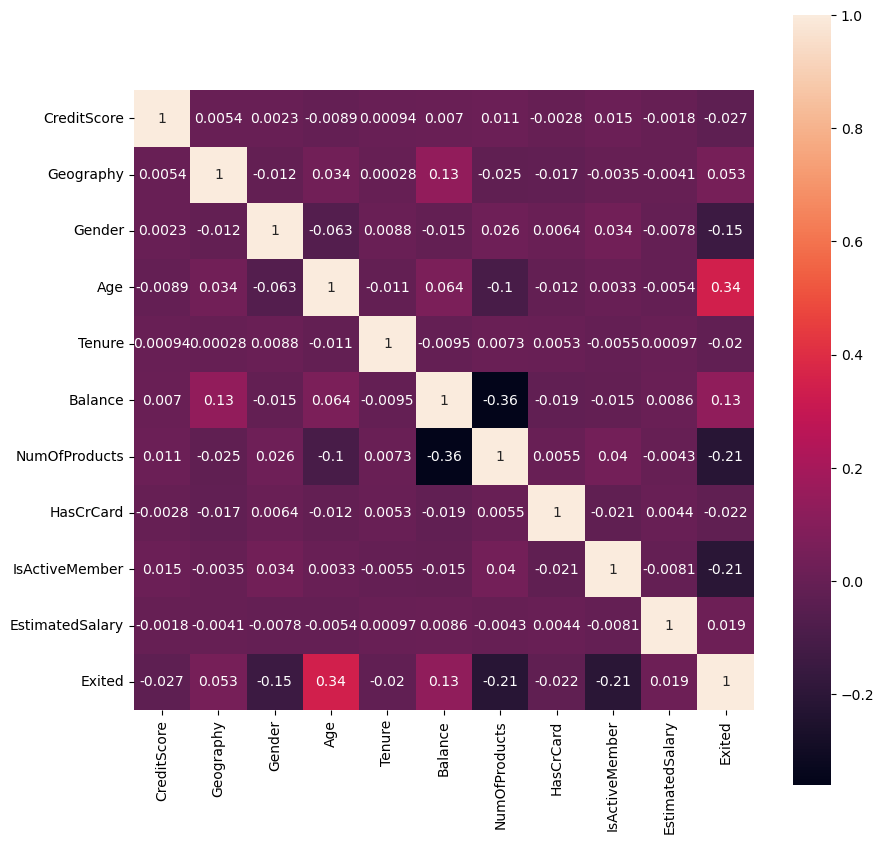

In [9]:
correlation_matrix = correlation.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix,square=True, annot=True)
plt.show()

In [10]:
for column in correlation.columns:
    if column != "Exited":
        print(f"{column}:\nCorrelation with target: {correlation[column].corr(correlation['Exited'])}\n\n")

CreditScore:
Correlation with target: -0.02738260006165168


Geography:
Correlation with target: 0.05334343123704925


Gender:
Correlation with target: -0.1464415589539307


Age:
Correlation with target: 0.3407681634075804


Tenure:
Correlation with target: -0.019564844484077474


Balance:
Correlation with target: 0.12974286048401104


NumOfProducts:
Correlation with target: -0.21455423158490433


HasCrCard:
Correlation with target: -0.02214133307230682


IsActiveMember:
Correlation with target: -0.2102370257921375


EstimatedSalary:
Correlation with target: 0.01882680567081288



In [11]:
for column in list(correlation.columns):
    print(f"{column}: {correlation[column].dtypes}")

CreditScore: int64
Geography: int64
Gender: int64
Age: float64
Tenure: int64
Balance: float64
NumOfProducts: int64
HasCrCard: float64
IsActiveMember: float64
EstimatedSalary: float64
Exited: int64


In [12]:
# Checking skewed data
print(correlation.skew())

CreditScore       -0.059291
Geography          0.725460
Gender            -0.259886
Age                0.968063
Tenure             0.006490
Balance            0.382020
NumOfProducts      0.368278
HasCrCard         -1.179255
IsActiveMember     0.008920
EstimatedSalary   -0.309022
Exited             1.412215
dtype: float64


In [13]:
print(correlation.nunique())

CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64


In [14]:
final_features = [column for column in relevant_feature_columns if abs(correlation[column].corr(correlation['Exited'])) > 0.1 ]

In [15]:
final_features

['Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember']

In [16]:
model = XGBClassifier(n_estimators=750, max_depth=5, n_jobs = 3) # Initialize model
X_train, X_val, y_train, y_val = train_test_split(correlation[final_features], correlation['Exited'], test_size=0.05, random_state=7) # Split data into training and validation
model.fit(X_train, y_train) # Train the model
model.score(X_val, y_val) # Evaluate the model

0.8545807077072225

In [17]:
test_data = pd.read_csv("../data/bank_churn_competition/test.csv")
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [18]:
test_data.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [19]:
test_data_relevant = test_data[final_features]
test_data_relevant.head()

,Gender,Age,Balance,NumOfProducts,IsActiveMember
0,Female,23.0,0.00,2,1.0
1,Female,46.0,0.00,1,0.0
2,Female,34.0,0.00,2,0.0
3,Male,36.0,0.00,1,0.0
4,Male,38.0,121263.62,1,0.0


In [20]:
test_data_relevant.select_dtypes(include='object')

,Gender
0,Female
1,Female
2,Female
3,Male
4,Male
...,...
110018,Male
110019,Female
110020,Male
110021,Female


In [21]:
test_data_relevant["Gender"] = gender_encoder.transform(test_data_relevant["Gender"])
test_data_relevant["Gender"]

0         0
1         0
2         0
3         1
4         1
         ..
110018    1
110019    0
110020    1
110021    0
110022    0
Name: Gender, Length: 110023, dtype: int64

In [22]:
test_data_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Gender          110023 non-null  int64  
 1   Age             110023 non-null  float64
 2   Balance         110023 non-null  float64
 3   NumOfProducts   110023 non-null  int64  
 4   IsActiveMember  110023 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 4.2 MB


In [23]:
prediction = model.predict_proba(test_data_relevant)

In [24]:
predicted_probabilities = prediction[:,1]
predicted_probabilities

array([0.01622159, 0.850681  , 0.02506888, ..., 0.01544759, 0.14201632,
       0.20305295], dtype=float32)

In [25]:
submission_df = pd.DataFrame({"id": test_data["id"], "Exited": predicted_probabilities})
submission_df

,id,Exited
0,165034,0.016222
1,165035,0.850681
2,165036,0.025069
3,165037,0.308610
4,165038,0.208060
...,...,...
110018,275052,0.033160
110019,275053,0.036473
110020,275054,0.015448
110021,275055,0.142016


In [26]:
# submission_df.to_csv("./submission.csv", index=False)

In [27]:
import torch.nn as nn
import torch
from torch.optim import Adam

In [28]:
class NetModel(nn.Module):
    
    def __init__(self, input_size, *args, **kwargs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12,4),
            nn.ReLU(),
            nn.Linear(4, 1)
            )

        
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.model(inputs))

In [29]:
test_data_relevant.shape

(110023, 5)

In [39]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [40]:
net_model = NetModel(input_size=5).to(device)

In [45]:
# Training 
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = Adam(params=net_model.parameters(),lr=learning_rate)

In [41]:
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32)).to(device)
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).to(device).view(y_train.shape[0],1)

In [47]:
epochs = 1000
for epoch in range(epochs):
    output = net_model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch loss: {loss}")

Epoch loss: 33.5820426940918
Epoch loss: 33.5817756652832
Epoch loss: 33.58148956298828
Epoch loss: 33.58116912841797
Epoch loss: 33.580780029296875
Epoch loss: 33.580326080322266
Epoch loss: 33.579837799072266
Epoch loss: 33.579280853271484
Epoch loss: 33.57865524291992
Epoch loss: 33.577938079833984


tensor(0.4442, device='mps:0', grad_fn=<MseLossBackward0>)

In [33]:
X_train.shape

(156782, 5)